In [8]:
# Helper functions for data processing and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from typing import Dict, List, Optional, Tuple
import polars as pl
from movedb.core import Trial
from movedb.file_io import sto_to_df
from src.grouping import trim_and_spline

def process_trial_data(trial_pkl: str, files: dict, trial, mass: float, 
                      stance_swing_sequence: list, stance_gait_pct: pl.Series, 
                      swing_gait_pct: pl.Series) -> Tuple[Dict[str, List[pl.DataFrame]], Dict[str, List[pl.DataFrame]]]:
    """
    Process IK and ID data for a single trial.
    
    Returns:
        Tuple of (session_ik, session_id) dictionaries
    """
    session_ik = {"Left": [], "Right": []}
    session_id = {"Left": [], "Right": []}
    
    ik_file = files.get('ik', None)
    id_file = files.get('id', None)
    
    for side in ['Left', 'Right']:
        phases = trial.get_event_sequences(stance_swing_sequence)
        for phase in phases:
            stance_phase = phase[:4]
            swing_phase = phase[3:]
            stance_times = [event.get_time(trial.points.rate) for event in stance_phase]
            swing_times = [event.get_time(trial.points.rate) for event in swing_phase]
            
            # Process IK data
            if ik_file:
                try:
                    ik_df, _ = sto_to_df(ik_file)
                    stance_ik = trim_and_spline(ik_df, start=stance_times[0], end=stance_times[-1], num_points=100)
                    swing_ik = trim_and_spline(ik_df, start=swing_times[0], end=swing_times[-1], num_points=100)
                    
                    stance_ik = stance_ik.with_columns(stance_gait_pct)
                    swing_ik = swing_ik.with_columns(swing_gait_pct)
                    
                    spline_ik = pl.concat([stance_ik, swing_ik]).sort('gait_percentage')
                    session_ik[side].append(spline_ik)
                except Exception as e:
                    print(f"Error processing IK file for trial {trial_pkl}: {e}")
            
            # Process ID data
            if id_file:
                try:
                    id_df, _ = sto_to_df(id_file)
                    stance_id = trim_and_spline(id_df, start=stance_times[0], end=stance_times[-1], num_points=100)
                    swing_id = trim_and_spline(id_df, start=swing_times[0], end=swing_times[-1], num_points=100)
                    
                    # Normalize by mass (exclude time column)
                    stance_id = stance_id.with_columns(pl.exclude('time') / mass)
                    swing_id = swing_id.with_columns(pl.exclude('time') / mass)
                    
                    stance_id = stance_id.with_columns(stance_gait_pct)
                    swing_id = swing_id.with_columns(swing_gait_pct)
                    
                    spline_id = pl.concat([stance_id, swing_id]).sort('gait_percentage')
                    session_id[side].append(spline_id)
                except Exception as e:
                    print(f"Error processing ID file for trial {trial_pkl}: {e}")
    
    return session_ik, session_id


def average_session_data(session_data: Dict[str, List[pl.DataFrame]]) -> Dict[str, Optional[pl.DataFrame]]:
    """
    Average session data across trials for each side.
    
    Args:
        session_data: Dictionary with 'Left' and 'Right' keys containing lists of DataFrames
        
    Returns:
        Dictionary with averaged DataFrames for each side (None if no data)
    """
    averaged_data = {"Left": None, "Right": None}
    
    for side in ['Left', 'Right']:
        if session_data[side]:
            # Find common columns across all DataFrames before concatenation
            common_cols = set(session_data[side][0].columns)
            for df in session_data[side][1:]:
                common_cols = common_cols.intersection(set(df.columns))
            common_cols = list(common_cols)
            
            # Select only common columns for concatenation
            aligned_dfs = [df.select(common_cols) for df in session_data[side]]
            combined_data = pl.concat(aligned_dfs)
            
            # Get all numeric columns except 'gait_percentage' for averaging
            numeric_cols = [col for col in combined_data.columns if col != 'gait_percentage' and combined_data[col].dtype.is_numeric()]
            avg_data = combined_data.group_by('gait_percentage').agg([
                pl.col(col).mean().alias(col) for col in numeric_cols
            ]).sort('gait_percentage')
            
            averaged_data[side] = avg_data
    
    return averaged_data


def process_group_results(group_results: dict, group_name: str, 
                         left_stance_swing: list, right_stance_swing: list,
                         stance_gait_pct: pl.Series, swing_gait_pct: pl.Series) -> Tuple[Dict[str, List], Dict[str, List]]:
    """
    Process all results for a group (control or old).
    
    Returns:
        Tuple of (group_ik, group_id) dictionaries
    """
    group_ik = {"Left": [], "Right": []}
    group_id = {"Left": [], "Right": []}
    
    print(f"Processing {group_name} group results...")
    
    for classification, subjects in group_results.items():
        for subject, sessions in subjects.items():
            for session, session_data in sessions.items():
                if session_data is None or not isinstance(session_data, dict):
                    continue
                    
                walking_trials = session_data.get('walking_trials', [])
                session_ik_data = {"Left": [], "Right": []}
                session_id_data = {"Left": [], "Right": []}
                
                for trial_pkl, files in walking_trials.items():
                    trial = Trial.from_pkl(trial_pkl)
                    mass = trial.parameters.get('Mass', 0.1)
                    
                    # Process trial for each side
                    for side in ['Left', 'Right']:
                        stance_swing_sequence = right_stance_swing if side == 'Right' else left_stance_swing
                        trial_ik, trial_id = process_trial_data(
                            trial_pkl, files, trial, mass, stance_swing_sequence,
                            stance_gait_pct, swing_gait_pct
                        )
                        session_ik_data[side].extend(trial_ik[side])
                        session_id_data[side].extend(trial_id[side])
                
                # Average session data and add to group data
                avg_ik = average_session_data(session_ik_data)
                avg_id = average_session_data(session_id_data)
                
                for side in ['Left', 'Right']:
                    if avg_ik[side] is not None:
                        group_ik[side].append(avg_ik[side])
                    if avg_id[side] is not None:
                        group_id[side].append(avg_id[side])
    
    return group_ik, group_id


def calculate_overall_statistics(group_data: Dict[str, List], data_type: str = "IK") -> Dict[str, Optional[pl.DataFrame]]:
    """
    Calculate overall mean and standard deviation statistics for a group.
    
    Args:
        group_data: Dictionary with 'Left' and 'Right' keys containing lists of DataFrames
        data_type: Type of data for printing ("IK" or "ID")
        
    Returns:
        Dictionary with overall statistics for each side
    """
    overall_stats = {"Left": None, "Right": None}
    
    for side in ['Left', 'Right']:
        if group_data[side]:
            # Find common columns across all session DataFrames
            common_cols = set(group_data[side][0].columns)
            for df in group_data[side][1:]:
                common_cols = common_cols.intersection(set(df.columns))
            common_cols = list(common_cols)
            
            # Select only common columns for concatenation
            aligned_dfs = [df.select(common_cols) for df in group_data[side]]
            all_sessions_data = pl.concat(aligned_dfs)
            
            # Calculate overall mean and std across all sessions
            numeric_cols = [col for col in all_sessions_data.columns if col != 'gait_percentage' and all_sessions_data[col].dtype.is_numeric()]
            
            overall_mean = all_sessions_data.group_by('gait_percentage').agg([
                pl.col(col).mean().alias(f"{col}_mean") for col in numeric_cols
            ]).sort('gait_percentage')
            
            overall_std = all_sessions_data.group_by('gait_percentage').agg([
                pl.col(col).std().alias(f"{col}_std") for col in numeric_cols
            ]).sort('gait_percentage')
            
            # Combine mean and std
            overall_stats[side] = overall_mean.join(overall_std, on='gait_percentage')
            
            print(f"{data_type} {side} side: {len(group_data[side])} sessions, {len(numeric_cols)} variables")
    
    return overall_stats


def create_comparison_plot(control_stats: Dict, old_stats: Dict, 
                          title: str, ylabel: str, exclude_cols: List[str] = None) -> None:
    """
    Create comparison plots between control and old groups.
    
    Args:
        control_stats: Statistics for control group
        old_stats: Statistics for old group  
        title: Plot title
        ylabel: Y-axis label
        exclude_cols: Columns to exclude from plotting
    """
    if exclude_cols is None:
        exclude_cols = ['time']
    
    # Find sample side that has data
    sample_side = None
    for side in ['Left', 'Right']:
        if control_stats[side] is not None or old_stats[side] is not None:
            sample_side = side
            break
    
    if sample_side is None:
        print("No data available for plotting")
        return
    
    # Get all available columns from both groups
    all_mean_cols = set()
    if control_stats[sample_side] is not None:
        all_mean_cols.update([col for col in control_stats[sample_side].columns if col.endswith('_mean')])
    if old_stats[sample_side] is not None:
        all_mean_cols.update([col for col in old_stats[sample_side].columns if col.endswith('_mean')])
    
    mean_cols = [col for col in all_mean_cols if col.replace('_mean', '') not in exclude_cols]
    n_vars = len(mean_cols)
    
    print(f"Creating comparison plots for {n_vars} variables...")
    
    # Calculate subplot layout
    n_cols = min(4, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle(title, fontsize=16)
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for var_idx, mean_col in enumerate(mean_cols):
        row = var_idx // n_cols
        col = var_idx % n_cols
        ax = axes[row, col]
        
        var_name = mean_col.replace('_mean', '')
        
        # Plot control group data
        for side in ['Left', 'Right']:
            if control_stats[side] is not None:
                stats_df = control_stats[side]
                std_col = f"{var_name}_std"
                
                if mean_col in stats_df.columns and std_col in stats_df.columns:
                    gait_pct = stats_df['gait_percentage'].to_numpy()
                    mean_vals = stats_df[mean_col].to_numpy()
                    std_vals = stats_df[std_col].to_numpy()
                    
                    color = 'blue' if side == 'Left' else 'red'
                    
                    # Plot mean line (solid for control)
                    ax.plot(gait_pct, mean_vals, color=color, linewidth=2, 
                           linestyle='-', label=f'Control {side}', alpha=0.8)
                    
                    # Plot standard deviation as shaded area
                    ax.fill_between(gait_pct, mean_vals - std_vals, mean_vals + std_vals, 
                                   color=color, alpha=0.2)
        
        # Plot old group data
        for side in ['Left', 'Right']:
            if old_stats[side] is not None:
                stats_df = old_stats[side]
                std_col = f"{var_name}_std"
                
                if mean_col in stats_df.columns and std_col in stats_df.columns:
                    gait_pct = stats_df['gait_percentage'].to_numpy()
                    mean_vals = stats_df[mean_col].to_numpy()
                    std_vals = stats_df[std_col].to_numpy()
                    
                    color = 'blue' if side == 'Left' else 'red'
                    
                    # Plot mean line (dashed for old)
                    ax.plot(gait_pct, mean_vals, color=color, linewidth=2, 
                           linestyle='--', label=f'Old {side}', alpha=0.8)
                    
                    # Plot standard deviation as shaded area
                    ax.fill_between(gait_pct, mean_vals - std_vals, mean_vals + std_vals, 
                                   color=color, alpha=0.1)
        
        # Add vertical line to mark stance-swing transition
        ax.axvline(x=50, color='gray', linestyle=':', alpha=0.7, linewidth=1)
        
        ax.set_title(var_name)
        ax.set_xlabel('Gait %')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 100)
    
    # Hide empty subplots
    for var_idx in range(n_vars, n_rows * n_cols):
        row = var_idx // n_cols
        col = var_idx % n_cols
        axes[row, col].set_visible(False)
    
    # Create external legend
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, linestyle='-', alpha=0.8, label='Control Left'),
        Line2D([0], [0], color='red', lw=2, linestyle='-', alpha=0.8, label='Control Right'),
        Line2D([0], [0], color='blue', lw=2, linestyle='--', alpha=0.8, label='Old Left'),
        Line2D([0], [0], color='red', lw=2, linestyle='--', alpha=0.8, label='Old Right'),
        Line2D([0], [0], color='gray', linestyle=':', alpha=0.7, label='Stance-Swing Transition')
    ]
    fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, 0.02))
    
    plt.tight_layout()
    plt.show()

print("Helper functions loaded!")

Helper functions loaded!


In [9]:
import os 
import json
import numpy as np
import polars as pl

root_dir = os.path.join('C:\\', 'Users', 'hpb7kr', 'OneDrive - University of Virginia', 'Shared Documents - MAMP Lab Folder', 'General', 'MoCapData', 'ViconData', 'Rats')

# Process all control group results
print("Processing control group results...")
control_results_file = os.path.join(root_dir, 'control_group_results.json')
old_results_file = os.path.join(root_dir, 'old_group_results.json')


with open(control_results_file, 'r') as f:
    control_results = json.load(f)

with open(old_results_file, 'r') as f:
    old_results = json.load(f)

stance_gait_pct = pl.Series('gait_percentage', np.linspace(0, 50, 100))
swing_gait_pct = pl.Series('gait_percentage', np.linspace(50, 100, 100))

left_stance_swing = [
    ('Left', 'Foot Strike'),
    ('Right', 'Foot Off'),
    ('Right', 'Foot Strike'),
    ('Left', 'Foot Off'),
    ('Left', 'Foot Strike'),
    ('Right', 'Foot Off'),
    ('Right', 'Foot Strike'),
]

right_stance_swing = [
    ('Right', 'Foot Strike'),
    ('Left', 'Foot Off'),
    ('Left', 'Foot Strike'),
    ('Right', 'Foot Off'),
    ('Right', 'Foot Strike'),
    ('Left', 'Foot Off'),
    ('Left', 'Foot Strike'),
]
# Process both groups using helper functions
control_ik, control_id = process_group_results(
    control_results, "control", left_stance_swing, right_stance_swing,
    stance_gait_pct, swing_gait_pct
)

old_ik, old_id = process_group_results(
    old_results, "old", left_stance_swing, right_stance_swing, 
    stance_gait_pct, swing_gait_pct
)

Processing control group results...
Processing control group results...
Processing old group results...


Calculating overall statistics for IK data...
IK Left side: 64 sessions, 23 variables
IK Right side: 73 sessions, 23 variables
IK Left side: 3 sessions, 23 variables
IK Right side: 2 sessions, 23 variables
Creating comparison plots for 13 variables...


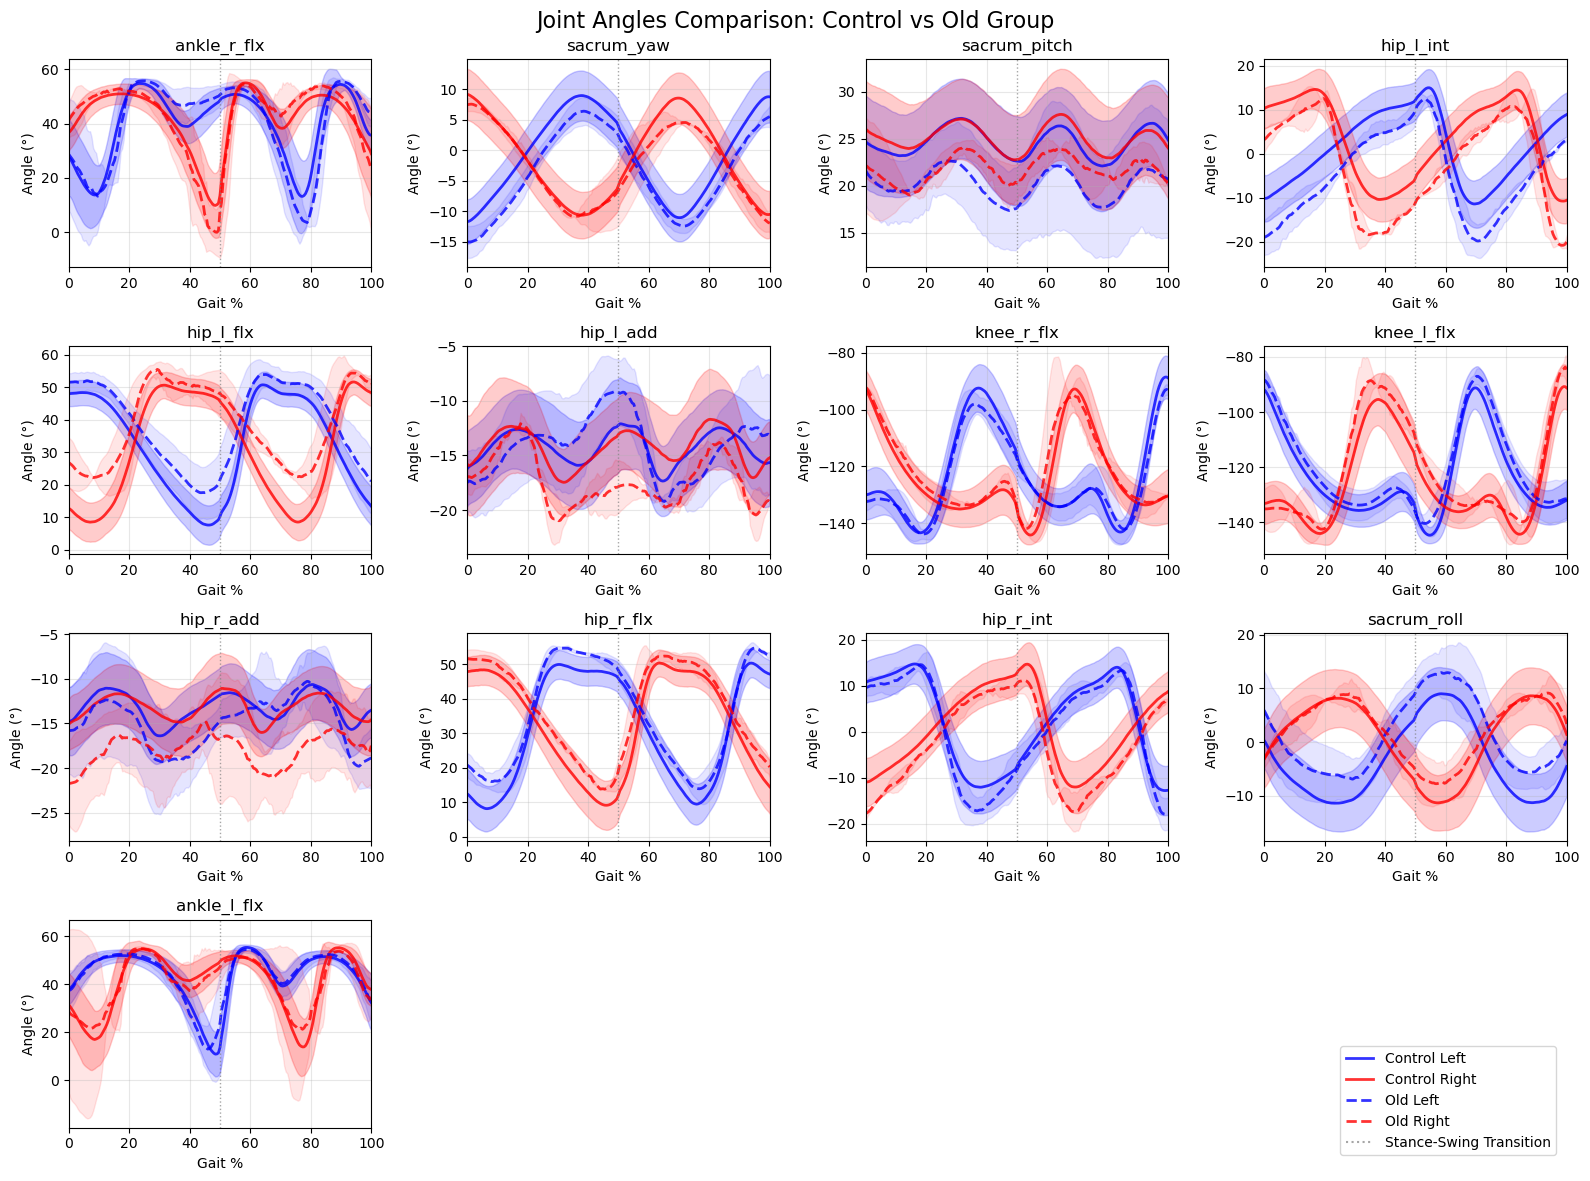

IK plotting complete!


In [10]:
# Calculate and plot IK statistics
print("Calculating overall statistics for IK data...")
overall_control_stats = calculate_overall_statistics(control_ik, "IK")
overall_old_stats = calculate_overall_statistics(old_ik, "IK")

# Create IK comparison plots
exclude_cols = [
    'time', 'sacrum_x', 'sacrum_y', 'sacrum_z', 
    'sacroiliac_r_flx', 'sacroiliac_l_flx', 
    'ankle_l_add', 'ankle_l_int', 'ankle_r_add', 'ankle_r_int'
]

create_comparison_plot(
    overall_control_stats, overall_old_stats,
    'Joint Angles Comparison: Control vs Old Group', 
    'Angle (°)', 
    exclude_cols
)

print("IK plotting complete!")

Calculating overall statistics for ID data...
ID Left side: 64 sessions, 23 variables
ID Right side: 73 sessions, 23 variables
ID Left side: 3 sessions, 23 variables
ID Right side: 2 sessions, 23 variables
Creating comparison plots for 22 variables...


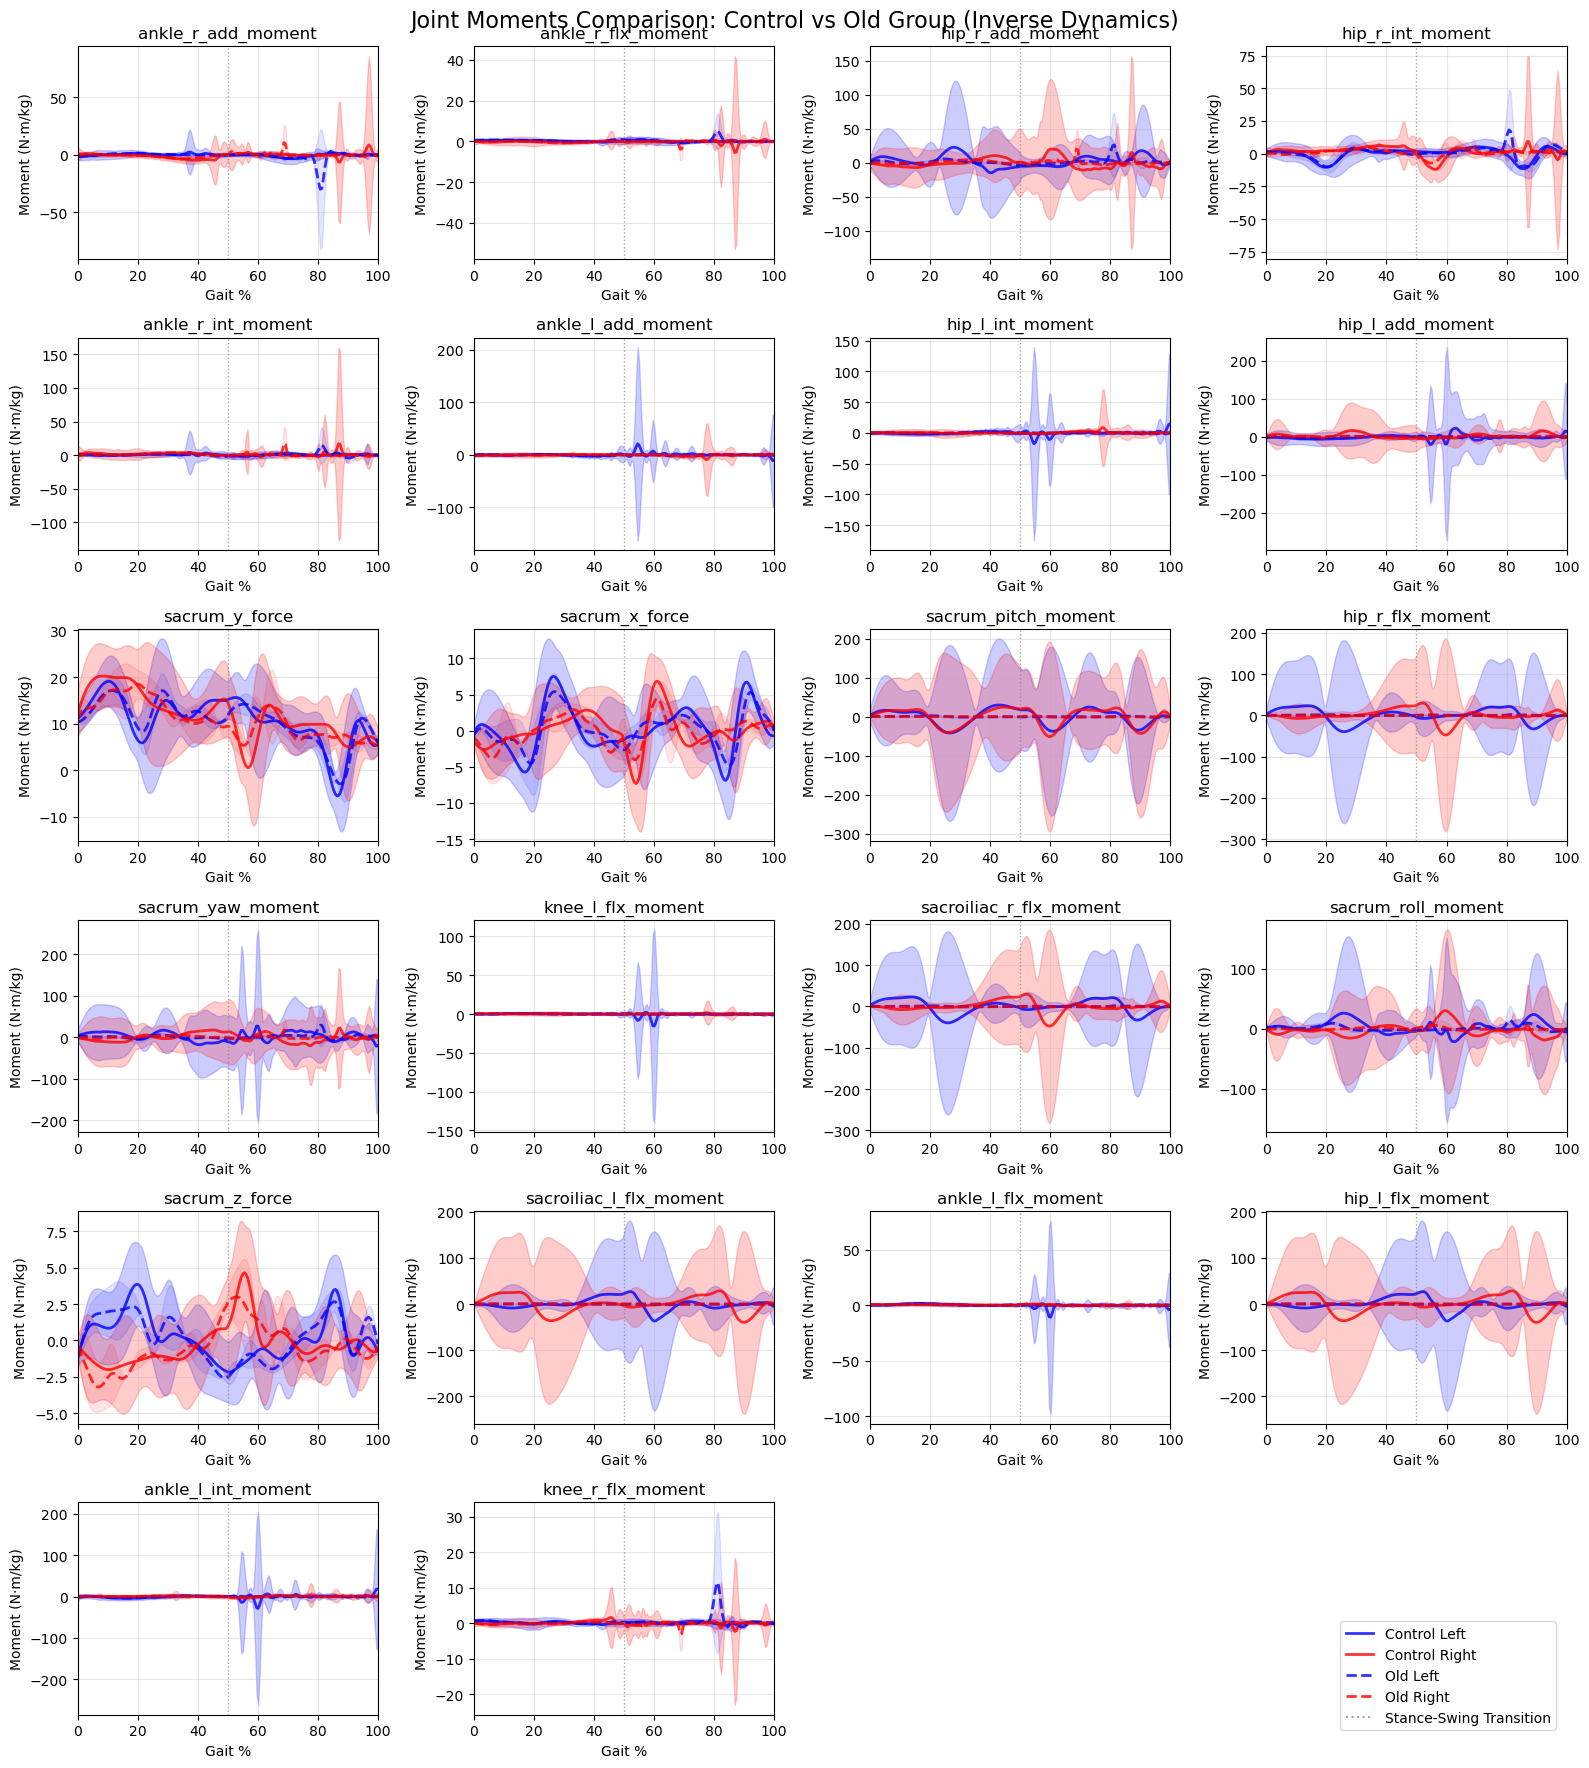

ID plotting complete!


In [11]:
# Calculate and plot ID statistics
print("Calculating overall statistics for ID data...")
overall_control_id_stats = calculate_overall_statistics(control_id, "ID")
overall_old_id_stats = calculate_overall_statistics(old_id, "ID")

# Create ID comparison plots
create_comparison_plot(
    overall_control_id_stats, overall_old_id_stats,
    'Joint Moments Comparison: Control vs Old Group (Inverse Dynamics)', 
    'Moment (N·m/kg)'
)

print("ID plotting complete!")

Creating plots for old group inverse dynamics only...
Creating plots for 22 joint moments...


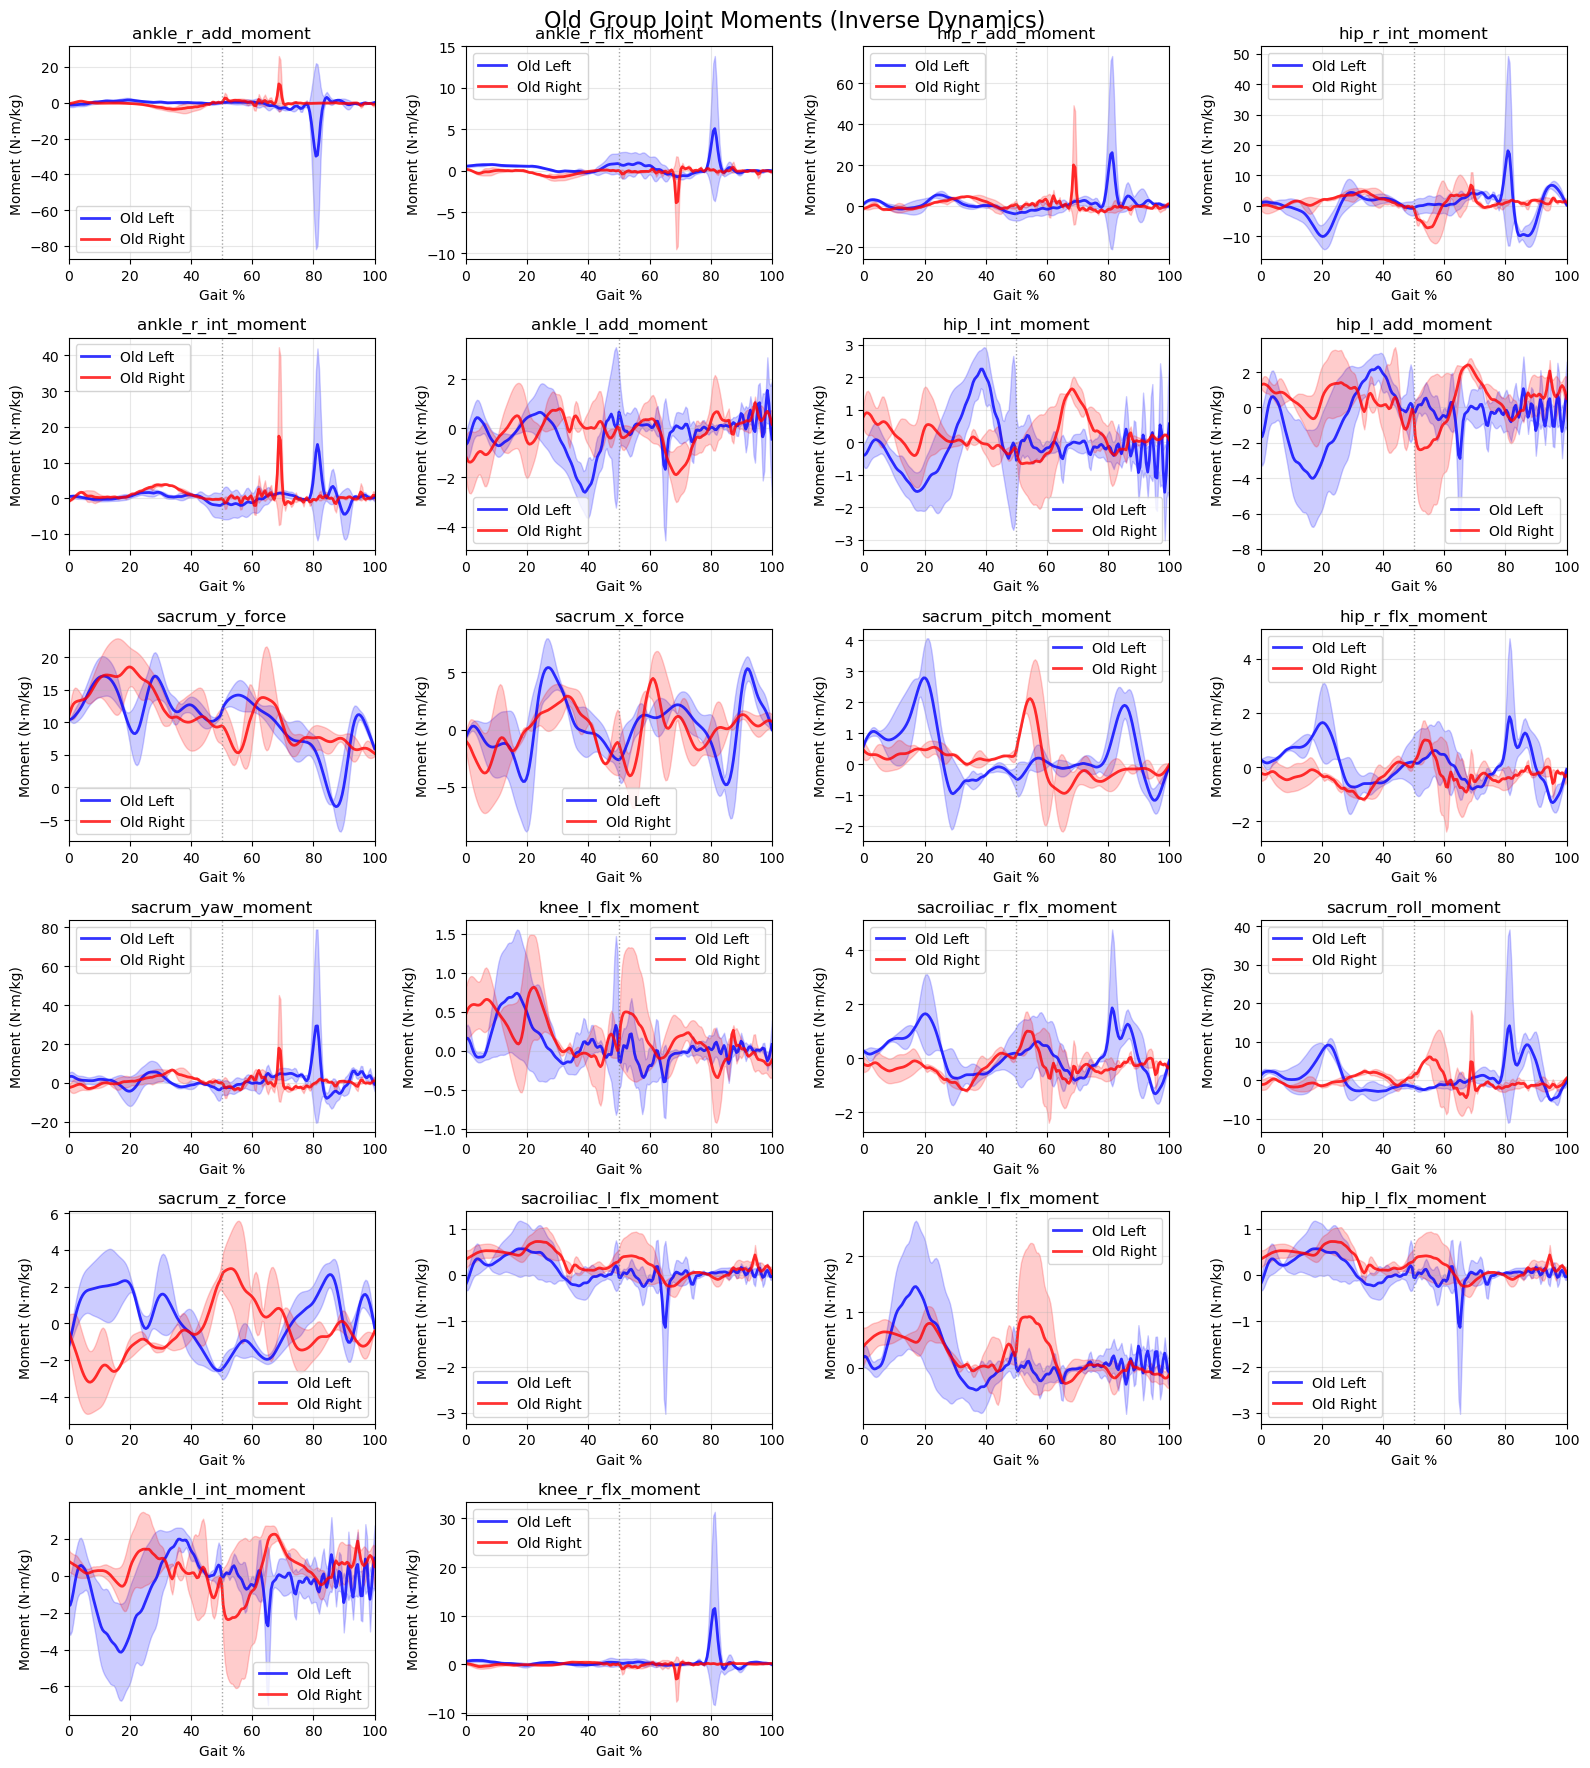

Old group ID plotting complete!


In [12]:
# Plot only old group inverse dynamics
print("Creating plots for old group inverse dynamics only...")

if overall_old_id_stats is not None:
    # Find sample side that has data
    sample_side = None
    for side in ['Left', 'Right']:
        if overall_old_id_stats[side] is not None:
            sample_side = side
            break
    
    if sample_side is not None:
        # Get all available joint moment columns
        all_mean_cols = set()
        all_mean_cols.update([col for col in overall_old_id_stats[sample_side].columns if col.endswith('_mean')])
        
        # Filter out time column
        exclude_cols = ['time']
        mean_cols = [col for col in all_mean_cols if col.replace('_mean', '') not in exclude_cols]
        n_joints = len(mean_cols)
        
        print(f"Creating plots for {n_joints} joint moments...")
        
        # Calculate subplot layout
        n_cols = min(4, n_joints)
        n_rows = (n_joints + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
        fig.suptitle('Old Group Joint Moments (Inverse Dynamics)', fontsize=16)
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for joint_idx, mean_col in enumerate(mean_cols):
            row = joint_idx // n_cols
            col = joint_idx % n_cols
            ax = axes[row, col]
            
            joint_name = mean_col.replace('_mean', '')
            
            # Plot old group data for both sides
            for side in ['Left', 'Right']:
                if overall_old_id_stats[side] is not None:
                    stats_df = overall_old_id_stats[side]
                    std_col = f"{joint_name}_std"
                    
                    if mean_col in stats_df.columns and std_col in stats_df.columns:
                        gait_pct = stats_df['gait_percentage'].to_numpy()
                        mean_vals = stats_df[mean_col].to_numpy()
                        std_vals = stats_df[std_col].to_numpy()
                        
                        color = 'blue' if side == 'Left' else 'red'
                        
                        # Plot mean line
                        ax.plot(gait_pct, mean_vals, color=color, linewidth=2, 
                               linestyle='-', label=f'Old {side}', alpha=0.8)
                        
                        # Plot standard deviation as shaded area
                        ax.fill_between(gait_pct, mean_vals - std_vals, mean_vals + std_vals, 
                                       color=color, alpha=0.2)
            
            # Add vertical line to mark stance-swing transition
            ax.axvline(x=50, color='gray', linestyle=':', alpha=0.7, linewidth=1)
            
            ax.set_title(joint_name)
            ax.set_xlabel('Gait %')
            ax.set_ylabel('Moment (N·m/kg)')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 100)
            ax.legend()
        
        # Hide empty subplots
        for joint_idx in range(n_joints, n_rows * n_cols):
            row = joint_idx // n_cols
            col = joint_idx % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No old group ID data available for plotting")
else:
    print("Old group ID statistics not calculated yet")

print("Old group ID plotting complete!")